# Deep Q-Network (DQN) - CartPole

Training an agent to balance a pole on a cart using Deep Q-Learning.

Based on: https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

## 1. Setup and Imports

In [16]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## 2. Create CartPole Environment

In [17]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Confirm observation and action spaces
print(f"Observation Space: {env.observation_space}")
print(f"Observation Shape: {env.observation_space.shape}")
print(f"Action Space: {env.action_space}")
print(f"Number of Actions: {env.action_space.n}")

# Get dimensions
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n
print(f"\nObservations: {n_observations}, Actions: {n_actions}")

Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Observation Shape: (4,)
Action Space: Discrete(2)
Number of Actions: 2

Observations: 4, Actions: 2


## 3. Replay Memory

Buffer to store transitions (state, action, reward, next_state, done) for experience replay.

In [18]:
# Named tuple for transitions
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    """Replay buffer to store and sample transitions."""
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

print("Replay Memory class defined.")

Replay Memory class defined.


## 4. Q-Network (Neural Network Approximator)

Three-layer fully-connected network that takes state as input and outputs Q-values for each action.

In [19]:
class DQN(nn.Module):
    """Deep Q-Network."""
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

print("DQN class defined.")

DQN class defined.


## 5. Hyperparameters

In [20]:
# Hyperparameters
BATCH_SIZE = 128        # Number of transitions sampled from replay buffer
GAMMA = 0.99            # Discount factor
EPS_START = 0.9         # Starting epsilon (exploration rate)
EPS_END = 0.05          # Minimum epsilon
EPS_DECAY = 1000        # Decay rate for epsilon
TAU = 0.005             # Update rate for target network (soft update)
LR = 1e-4               # Learning rate
MEMORY_SIZE = 10000     # Replay buffer capacity
NUM_EPISODES = 600      # Number of training episodes

print("Hyperparameters set.")

Hyperparameters set.


## 6. Initialize Networks and Optimizer

- **Policy Network**: Used to select actions
- **Target Network**: Used to compute target Q-values (updated periodically)

In [21]:
# Initialize policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  # Copy weights

# Optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Replay memory
memory = ReplayMemory(MEMORY_SIZE)

# Track steps for epsilon decay
steps_done = 0

print("Networks and optimizer initialized.")
print(f"Policy Network: {policy_net}")

Networks and optimizer initialized.
Policy Network: DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)


## 7. Action Selection (ε-greedy)

Balance exploration (random actions) and exploitation (best known action).
Epsilon decays over time from EPS_START to EPS_END.

In [22]:
def select_action(state):
    """Select action using epsilon-greedy policy."""
    global steps_done
    sample = random.random()
    
    # Calculate current epsilon (decays over time)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        # Exploit: choose best action from policy network
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Explore: choose random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

print("Action selection function defined.")

Action selection function defined.


## 8. Optimization Step

Compute DQN loss (Huber loss on TD error), backpropagate, and update weights.

In [23]:
def optimize_model():
    """Perform one step of optimization on the policy network."""
    if len(memory) < BATCH_SIZE:
        return
    
    # Sample a batch from replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # Create mask for non-final states
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s, a) - the model computes Q(s), then we select the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s') for all next states using target network
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute expected Q values: r + gamma * max(Q(s', a'))
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)  # Gradient clipping
    optimizer.step()

print("Optimization function defined.")

Optimization function defined.


## 9. Training Loop

In [24]:
# Storage for plotting
episode_rewards = []
episode_durations = []

print(f"Starting training for {NUM_EPISODES} episodes...")
print("="*50)

for i_episode in range(NUM_EPISODES):
    # Initialize environment and state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    total_reward = 0
    
    for t in count():
        # Select and perform action
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Store transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to next state
        state = next_state
        
        # Perform optimization step
        optimize_model()
        
        # Soft update target network: θ' = τ*θ + (1-τ)*θ'
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)
            break
    
    # Print progress every 50 episodes
    if (i_episode + 1) % 50 == 0:
        avg_reward = sum(episode_rewards[-100:]) / min(len(episode_rewards), 100)
        print(f"Episode {i_episode + 1}/{NUM_EPISODES} | "
              f"Reward: {total_reward:.0f} | "
              f"Avg (last 100): {avg_reward:.2f}")

print("="*50)
print("Training complete!")
env.close()

Starting training for 600 episodes...
Episode 50/600 | Reward: 14 | Avg (last 100): 16.18
Episode 100/600 | Reward: 9 | Avg (last 100): 13.68
Episode 150/600 | Reward: 17 | Avg (last 100): 12.46
Episode 200/600 | Reward: 108 | Avg (last 100): 35.19
Episode 250/600 | Reward: 110 | Avg (last 100): 83.47
Episode 300/600 | Reward: 122 | Avg (last 100): 111.93
Episode 350/600 | Reward: 129 | Avg (last 100): 116.86
Episode 400/600 | Reward: 116 | Avg (last 100): 118.37
Episode 450/600 | Reward: 124 | Avg (last 100): 115.90
Episode 500/600 | Reward: 140 | Avg (last 100): 122.04
Episode 550/600 | Reward: 75 | Avg (last 100): 131.23
Episode 600/600 | Reward: 63 | Avg (last 100): 108.97
Training complete!


## 10. Results - Plot Episode Returns

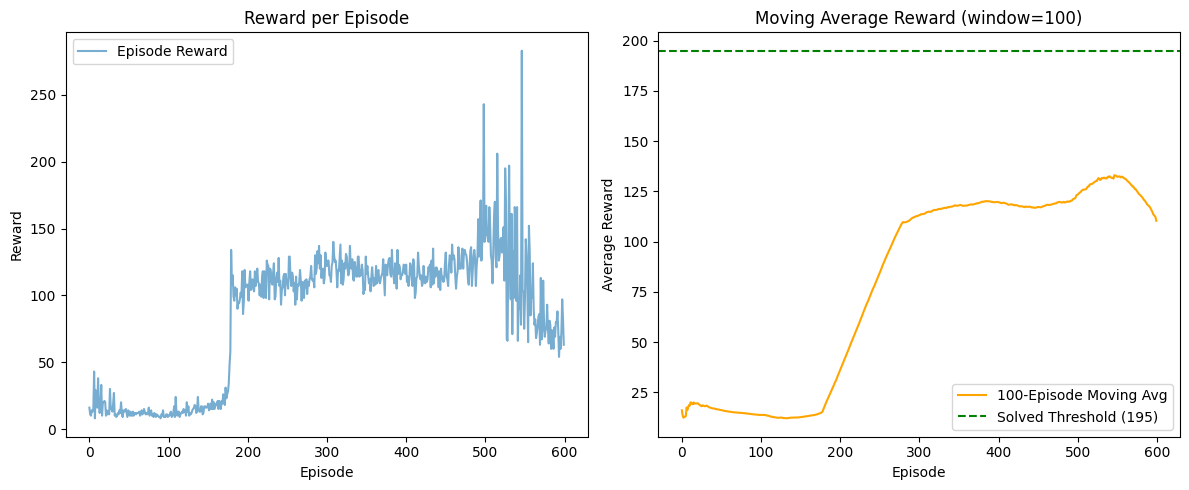

In [25]:
def plot_results(episode_rewards, window=100):
    """Plot episode rewards and moving average."""
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, alpha=0.6, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode')
    plt.legend()
    
    # Plot 2: Moving average
    plt.subplot(1, 2, 2)
    if len(episode_rewards) >= window:
        moving_avg = [sum(episode_rewards[max(0,i-window):i+1])/min(i+1, window) 
                      for i in range(len(episode_rewards))]
        plt.plot(moving_avg, color='orange', label=f'{window}-Episode Moving Avg')
        plt.axhline(y=195, color='g', linestyle='--', label='Solved Threshold (195)')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.title(f'Moving Average Reward (window={window})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_results(episode_rewards)

In [26]:
# Report statistics
print("=" * 50)
print("TRAINING RESULTS")
print("=" * 50)

# Final moving average (last 100 episodes)
final_avg = sum(episode_rewards[-100:]) / min(len(episode_rewards), 100)
print(f"Final Average Reward (last 100 episodes): {final_avg:.2f}")

# Find first episode where avg >= 195 (solved criterion)
threshold = 195
window = 100
solved_episode = None
for i in range(window - 1, len(episode_rewards)):
    avg = sum(episode_rewards[i-window+1:i+1]) / window
    if avg >= threshold:
        solved_episode = i + 1
        break

if solved_episode:
    print(f"Environment SOLVED at episode {solved_episode} (avg >= {threshold} over {window} episodes)")
else:
    print(f"Environment NOT solved (avg never reached {threshold} over {window} episodes)")

print(f"\nMax Reward: {max(episode_rewards):.0f}")
print(f"Min Reward: {min(episode_rewards):.0f}")

TRAINING RESULTS
Final Average Reward (last 100 episodes): 108.97
Environment NOT solved (avg never reached 195 over 100 episodes)

Max Reward: 283
Min Reward: 8


## 11. Experiments

### Experiment 1: Change Network Size
Modify the number of hidden layers or neurons.

In [27]:
# EXPERIMENT 1: Larger network (256 neurons instead of 128)
# Uncomment and modify the DQN class above, then retrain

# class DQN_Large(nn.Module):
#     def __init__(self, n_observations, n_actions):
#         super(DQN_Large, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 256)
#         self.layer2 = nn.Linear(256, 256)
#         self.layer3 = nn.Linear(256, n_actions)
#     
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)

print("Experiment 1: Network size modification (see comments)")

Experiment 1: Network size modification (see comments)


### Experiment 2: Adjust Learning Rate

In [28]:
# EXPERIMENT 2: Different learning rates
# Try: LR = 1e-3 (faster), LR = 1e-5 (slower)

# To test, change LR in hyperparameters section and retrain
# Compare results:
# - LR = 1e-4 (default): [your results]
# - LR = 1e-3 (faster):  [your results]
# - LR = 1e-5 (slower):  [your results]

print("Experiment 2: Learning rate adjustment (see comments)")

Experiment 2: Learning rate adjustment (see comments)


### Experiment 3: Modify ε Schedule

In [29]:
# EXPERIMENT 3: Different epsilon schedules
# Default: EPS_START=0.9, EPS_END=0.05, EPS_DECAY=1000

# Try:
# - Faster decay: EPS_DECAY = 500
# - Slower decay: EPS_DECAY = 2000
# - Higher minimum: EPS_END = 0.1

print("Experiment 3: Epsilon schedule modification (see comments)")

Experiment 3: Epsilon schedule modification (see comments)


## 12. Watch Trained Agent (Optional)

In [30]:
# Test the trained agent
def test_agent(num_episodes=5):
    """Run the trained agent and display results."""
    test_env = gym.make("CartPole-v1", render_mode="human")
    
    for episode in range(num_episodes):
        state, _ = test_env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0
        
        for t in count():
            with torch.no_grad():
                action = policy_net(state).max(1).indices.view(1, 1)
            
            observation, reward, terminated, truncated, _ = test_env.step(action.item())
            total_reward += reward
            
            if terminated or truncated:
                print(f"Test Episode {episode + 1}: Reward = {total_reward}")
                break
            
            state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    
    test_env.close()

# Uncomment to watch the trained agent:
# test_agent()

In [1]:
test_agent()

NameError: name 'test_agent' is not defined